# Chapter 6: Analysis & Visualization

**Data-Juicer User Guide**

- Git Commit: `v1.4.6`
- Commit Date: 2026-02-02
- Repository: https://github.com/datajuicer/data-juicer

# Table of Contents

1. [Setup](#setup)
2. [Create Sample Dataset](#create-sample-dataset)
3. [Run Data Analysis](#run-data-analysis)
4. [Show Analysis Results and Extract Parameters](#show-analysis-results-and-extract-parameters)
5. [Create Optimized Config File](#create-optimized-config-file)
6. [Process with Optimized Parameters](#process-with-optimized-parameters)
7. [Further Reading](#further-reading)

## Setup

In [1]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [2]:
# Install Data-Juicer (if not installed)
# If running in Google Colab, use 'pip install' instead of 'uv pip install'
# !uv pip install py-data-juicer

## Create Sample Dataset

In [3]:
os.makedirs('./data', exist_ok=True)

# Create diverse dataset for analysis
samples = [
    # Low quality samples (should be filtered)
    {"text": "!!!Click here NOW!!! Buy cheap stuff!!! Limited time offer!!!"},
    {"text": "Short text."},
    {"text": "x"},
    {"text": "😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀😀"},
    
    # Medium quality samples
    {"text": "This is OK but might need refinement for better quality and depth."},
    {"text": "The product is good. I like it. It works well. Very nice."},
    {"text": "Check this out: https://spam.com/fake https://scam.org/malware https://bad.link"},
    
    # High quality samples (should be kept)
    {"text": "Machine learning has revolutionized natural language processing by enabling models to understand context, semantics, and generate human-like text through transformer architectures."},
    {"text": "Climate change poses significant challenges to global ecosystems. Rising temperatures affect biodiversity, ocean levels, and weather patterns, requiring coordinated international action."},
    {"text": "The Renaissance period marked a cultural rebirth in Europe, characterized by advances in art, science, and philosophy. Leonardo da Vinci and Michelangelo epitomized this era's creative genius."},
    {"text": "Quantum computing leverages quantum mechanical phenomena like superposition and entanglement to solve complex problems exponentially faster than classical computers in specific domains."},
    {"text": "Effective data curation involves filtering noise, removing duplicates, standardizing formats, and ensuring diversity to create high-quality training datasets for machine learning models."},
    
    # Edge cases
    {"text": ""},
    {"text": "   "},
]


with open('./data/analysis_demo.jsonl', 'w') as f:
    for sample in samples:
        f.write(json.dumps(sample) + '\n')

print(f"Created dataset with {len(samples)} samples")

Created dataset with 14 samples


## Run Data Analysis

In [4]:
# Create analysis configuration
analysis_config = """project_name: 'analysis_demo'
dataset_path: './data/analysis_demo.jsonl'
export_path: './outputs/analysis_demo/analyzed.jsonl'
np: 2

export_original_dataset: true # Keep original dataset for further processing

# Operators to compute statistics
process:
  - language_id_score_filter:
      lang: 'en'
      min_score: 0.5
  - text_length_filter:
      min_len: 5
      max_len: 500
  - alphanumeric_filter:
      min_ratio: 0.3
"""

os.makedirs('./configs', exist_ok=True)
with open('./configs/analysis.yaml', 'w') as f:
    f.write(analysis_config)

print("Analysis configuration created")

Analysis configuration created


In [5]:
# Run analysis
!dj-analyze --config ./configs/analysis.yaml

2026-02-12 09:28:57.220 | INFO     | data_juicer.config.config:695 - dataset_path config is set and a valid local path
2026-02-12 09:28:57.278 | INFO     | data_juicer.config.config:1012 - Back up the input config file [/workspaces/data-juicer-hub/configs/analysis.yaml] into the work_dir [/workspaces/data-juicer-hub/outputs/analysis_demo]
2026-02-12 09:28:57.284 | INFO     | data_juicer.config.config:1033 - Configuration table: 
╒══════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════╕
│ key                      │ values                                                                                            │
╞══════════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════╡
│ config                   │ [Path_fr(./configs/analysis.yaml, cwd=/workspaces/data-juicer-hub)]                               │
├──────────────────────────┼───────────────────────

## Show Analysis Results and Extract Parameters

After running the analysis, let's examine the statistical distributions and use them to determine optimal filtering thresholds.

### Visualize Data Distributions

The analysis results (including visualizations and statistics) are automatically saved in the `analysis` folder within the same directory as the `export_path`.

Found 9 visualization(s), here are the first 3:



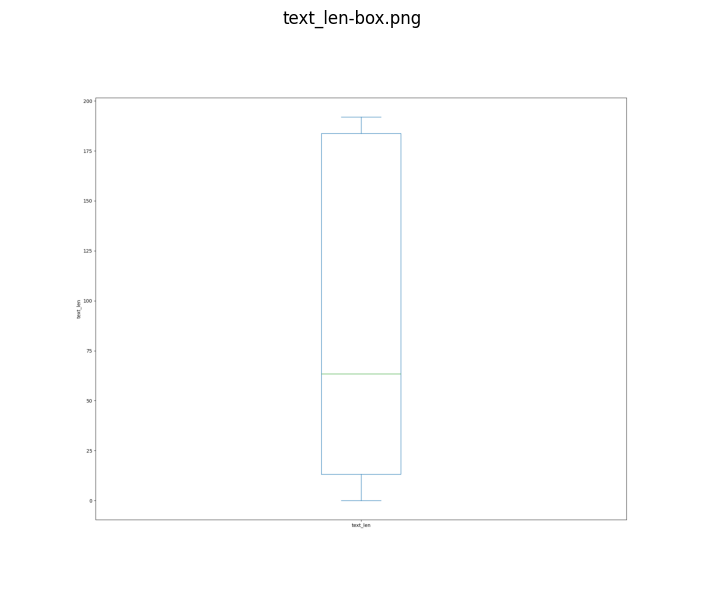

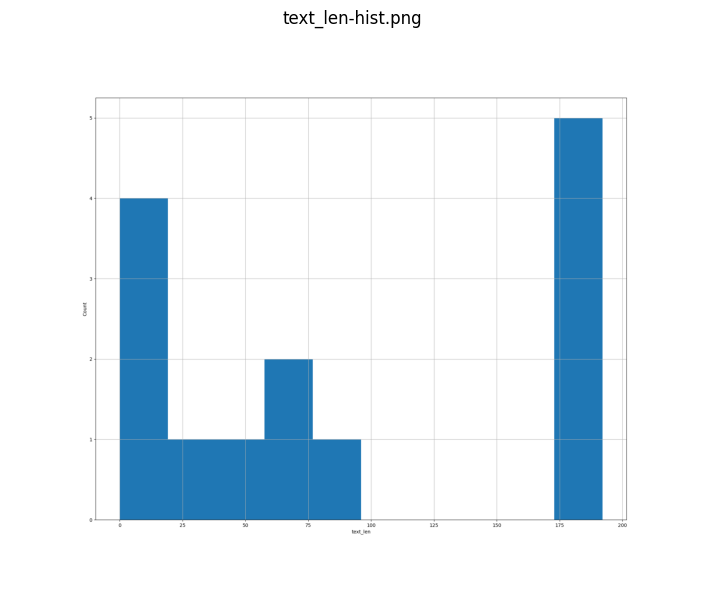

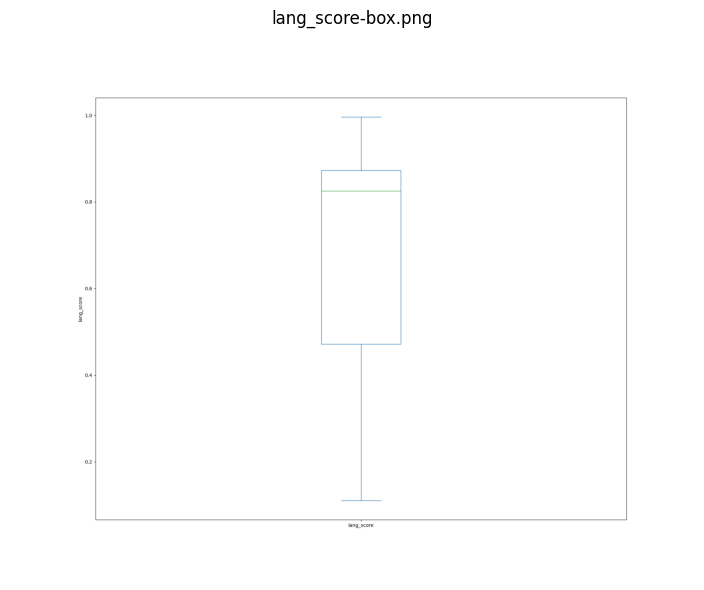

In [6]:
# Display generated histograms
analysis_dir = './outputs/analysis_demo/analysis'
if os.path.exists(analysis_dir):
    png_files = [f for f in os.listdir(analysis_dir) if f.endswith('.png')]
    
    if png_files:
        print(f"Found {len(png_files)} visualization(s), here are the first 3:\n")
        
        for png_file in png_files[:3]:  # Show first 3
            img_path = os.path.join(analysis_dir, png_file)
            img = Image.open(img_path)
            
            plt.figure(figsize=(10, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(png_file)
            plt.tight_layout()
            plt.show()
    else:
        print("No visualization files found")
else:
    print("Analysis directory not found")

### Extract Statistical Insights

Now we'll load the overall statistics and use **percentile-based filtering** to determine optimal thresholds:

In [7]:
# Load overall statistics
stats_file = './outputs/analysis_demo/analysis/overall.csv'
if os.path.exists(stats_file):
    overall_stats = pd.read_csv(stats_file)
    print("Overall Statistics:")
    print(overall_stats)
    
    # Extract key statistics for parameter tuning
    print("\n=== Analysis-Based Parameter Recommendations ===\n")
    
    # 1. Language Score Analysis - use 25th percentile
    lang_score_25th = overall_stats.loc[overall_stats['Unnamed: 0'] == '25%', 'lang_score'].values[0]
    lang_score_mean = overall_stats.loc[overall_stats['Unnamed: 0'] == 'mean', 'lang_score'].values[0]
    print(f"1. Language Score Filter:")
    print(f"   - Mean score: {lang_score_mean:.4f}")
    print(f"   - 25th percentile: {lang_score_25th:.4f}")
    print(f"   - Recommendation: Set min_score to {lang_score_25th:.4f} (filters bottom 25%)")
    
    # 2. Text Length Analysis - use 25th percentile
    text_len_25th = overall_stats.loc[overall_stats['Unnamed: 0'] == '25%', 'text_len'].values[0]
    text_len_mean = overall_stats.loc[overall_stats['Unnamed: 0'] == 'mean', 'text_len'].values[0]
    text_len_75th = overall_stats.loc[overall_stats['Unnamed: 0'] == '75%', 'text_len'].values[0]
    text_len_max = overall_stats.loc[overall_stats['Unnamed: 0'] == 'max', 'text_len'].values[0]
    print(f"\n2. Text Length Filter:")
    print(f"   - Mean length: {text_len_mean:.1f}")
    print(f"   - 25th percentile: {text_len_25th:.0f}")
    print(f"   - 75th percentile: {text_len_75th:.0f}")
    print(f"   - Recommendation: Set min_len={text_len_25th:.0f} (filters bottom 25%), max_len={text_len_75th * 1.5:.0f}")
    
    # 3. Alphanumeric Ratio Analysis - use 25th percentile
    alnum_25th = overall_stats.loc[overall_stats['Unnamed: 0'] == '25%', 'alnum_ratio'].values[0]
    alnum_mean = overall_stats.loc[overall_stats['Unnamed: 0'] == 'mean', 'alnum_ratio'].values[0]
    print(f"\n3. Alphanumeric Filter:")
    print(f"   - Mean ratio: {alnum_mean:.4f}")
    print(f"   - 25th percentile: {alnum_25th:.4f}")
    print(f"   - Recommendation: Set min_ratio to {alnum_25th:.4f} (filters bottom 25%)")
    
    # Generate optimized config based on 25th percentile
    optimized_config = {
        'language_id_score_filter': {
            'min_score': float(f"{lang_score_25th:.4f}")
        },
        'text_length_filter': {
            'min_len': int(text_len_25th),
            'max_len': int(text_len_75th * 1.5)  # Allow some flexibility above 75th percentile
        },
        'alphanumeric_filter': {
            'min_ratio': float(f"{alnum_25th:.4f}")
        }
    }
    
    print("\n=== Optimized Configuration (Bottom 25% Filtered) ===")
    import json
    print(json.dumps(optimized_config, indent=2))
    
    print("\n📊 Strategy: Using 25th percentile ensures only top 75% quality samples are retained")
else:
    print("Statistics file not found. Analysis may still be running.")


Overall Statistics:
   Unnamed: 0  alnum_ratio  lang  lang_score    text_len
0       count    14.000000  14.0   14.000000   14.000000
1        mean     0.649933   NaN    0.676335   87.642857
2         std     0.360406   NaN    0.333305   80.019812
3         min     0.000000   NaN    0.110449    0.000000
4         25%     0.688309   NaN    0.472179   13.250000
5         50%     0.818182   NaN    0.825066   63.500000
6         75%     0.864247   NaN    0.872459  183.750000
7         max     1.000000   NaN    0.996100  192.000000
8      unique          NaN   2.0         NaN         NaN
9         top          NaN    en         NaN         NaN
10       freq          NaN  13.0         NaN         NaN

=== Analysis-Based Parameter Recommendations ===

1. Language Score Filter:
   - Mean score: 0.6763
   - 25th percentile: 0.4722
   - Recommendation: Set min_score to 0.4722 (filters bottom 25%)

2. Text Length Filter:
   - Mean length: 87.6
   - 25th percentile: 13
   - 75th percentile: 184
  

## Create Optimized Config File

In [8]:
optimized_config_yaml = """
project_name: 'analysis_demo_optimized'
dataset_path: './outputs/analysis_demo/analyzed.jsonl' # Reuse samples with stats to save processing time
export_path: './outputs/process_demo_optimized/processed.jsonl'

np: 2

process:
  - language_id_score_filter:
      lang: en
      min_score: {lang_score}
  
  - text_length_filter:
      min_len: {min_len}
      max_len: {max_len}
  
  - alphanumeric_filter:
      min_ratio: {alnum_ratio}
""".format(
    lang_score=optimized_config['language_id_score_filter']['min_score'],
    min_len=optimized_config['text_length_filter']['min_len'],
    max_len=optimized_config['text_length_filter']['max_len'],
    alnum_ratio=optimized_config['alphanumeric_filter']['min_ratio']
)

# Save optimized config
os.makedirs('./configs', exist_ok=True)
with open('./configs/optimized_process.yaml', 'w') as f:
    f.write(optimized_config_yaml)

print("Optimized configuration saved to: ./configs/optimized_process.yaml")

Optimized configuration saved to: ./configs/optimized_process.yaml


## Process with Optimized Parameters

In [9]:
# --keep_stats_in_res_ds true: Preserve statistical information in the result dataset
#                               This allows skipping re-calculate in future iterations
!dj-process --config ./configs/optimized_process.yaml \
    --keep_stats_in_res_ds true

2026-02-12 09:29:33.336 | INFO     | data_juicer.config.config:695 - dataset_path config is set and a valid local path
2026-02-12 09:29:33.384 | INFO     | data_juicer.config.config:1012 - Back up the input config file [/workspaces/data-juicer-hub/configs/optimized_process.yaml] into the work_dir [/workspaces/data-juicer-hub/outputs/process_demo_optimized]
2026-02-12 09:29:33.389 | INFO     | data_juicer.config.config:1033 - Configuration table: 
╒══════════════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ key                      │ values                                                                                                     │
╞══════════════════════════╪════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ config                   │ [Path_fr(./configs/optimized_process.yaml, cwd=/workspaces/data-juicer-hub)]                              

Checking processed dataset

In [10]:
with open('./outputs/process_demo_optimized/processed.jsonl', 'r') as f:
    result = f.readlines()
    print(f"Processed dataset contains {len(result)} samples")
    for i, line in enumerate(result):
        print(f"{line}")

Processed dataset contains 8 samples
{"text":"This is OK but might need refinement for better quality and depth.","__dj__stats__":{"alnum_ratio":0.8181818182,"lang":"en","lang_score":0.9690003395,"text_len":66}}

{"text":"The product is good. I like it. It works well. Very nice.","__dj__stats__":{"alnum_ratio":0.7368421053,"lang":"en","lang_score":0.9961002469,"text_len":57}}

{"text":"Check this out: https:\/\/spam.com\/fake https:\/\/scam.org\/malware https:\/\/bad.link","__dj__stats__":{"alnum_ratio":0.746835443,"lang":"en","lang_score":0.8290334344,"text_len":79}}

{"text":"Machine learning has revolutionized natural language processing by enabling models to understand context, semantics, and generate human-like text through transformer architectures.","__dj__stats__":{"alnum_ratio":0.8666666667,"lang":"en","lang_score":0.8748974204,"text_len":180}}

{"text":"Climate change poses significant challenges to global ecosystems. Rising temperatures affect biodiversity, ocean levels, and

#### Re-analyze Processed Data

After processing, we re-analyze the processed dataset to:

- Verify processing effectiveness: Check if low-quality samples were removed
- Compare statistics: Before vs. after processing
- Validate quality improvement: Ensure metrics moved in the desired direction

In [11]:
!dj-analyze --config ./configs/optimized_process.yaml \
    --dataset_path ./outputs/process_demo_optimized/processed.jsonl \
    --export_path ./outputs/processed_analyzed/analyzed.jsonl

2026-02-12 09:29:53.699 | INFO     | data_juicer.config.config:695 - dataset_path config is set and a valid local path
2026-02-12 09:29:53.751 | INFO     | data_juicer.config.config:1012 - Back up the input config file [/workspaces/data-juicer-hub/configs/optimized_process.yaml] into the work_dir [/workspaces/data-juicer-hub/outputs/processed_analyzed]
2026-02-12 09:29:53.756 | INFO     | data_juicer.config.config:1033 - Configuration table: 
╒══════════════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ key                      │ values                                                                                                 │
╞══════════════════════════╪════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ config                   │ [Path_fr(./configs/optimized_process.yaml, cwd=/workspaces/data-juicer-hub)]                           │
├────────────────

In [12]:
# Load overall statistics
stats_file = './outputs/processed_analyzed/analysis/overall.csv'
if os.path.exists(stats_file):
    overall_stats = pd.read_csv(stats_file)
    print("Overall Statistics:")
    print(overall_stats)

Overall Statistics:
   Unnamed: 0  alnum_ratio lang  lang_score    text_len
0       count     8.000000  8.0    8.000000    8.000000
1        mean     0.826093  NaN    0.862787  141.375000
2         std     0.055751  NaN    0.080148   61.681063
3         min     0.736842  NaN    0.765276   57.000000
4         25%     0.800345  NaN    0.818704   75.750000
5         50%     0.846774  NaN    0.832204  182.500000
6         75%     0.865860  NaN    0.898423  186.000000
7         max     0.881081  NaN    0.996100  192.000000
8      unique          NaN  1.0         NaN         NaN
9         top          NaN   en         NaN         NaN
10       freq          NaN  8.0         NaN         NaN


Comparing 9 visualizations before and after processing



/tmp/ipykernel_12177/960525134.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


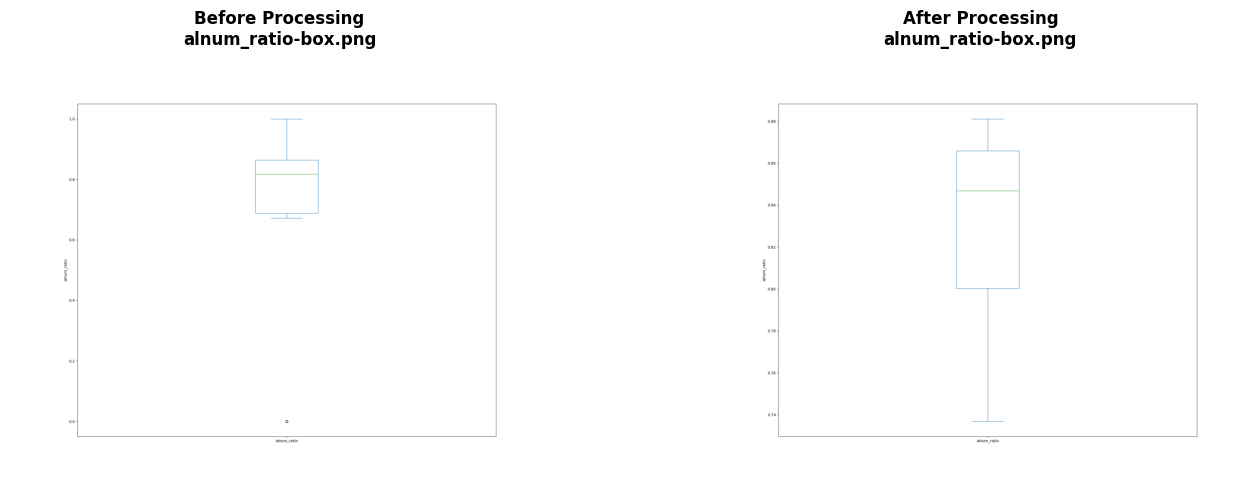

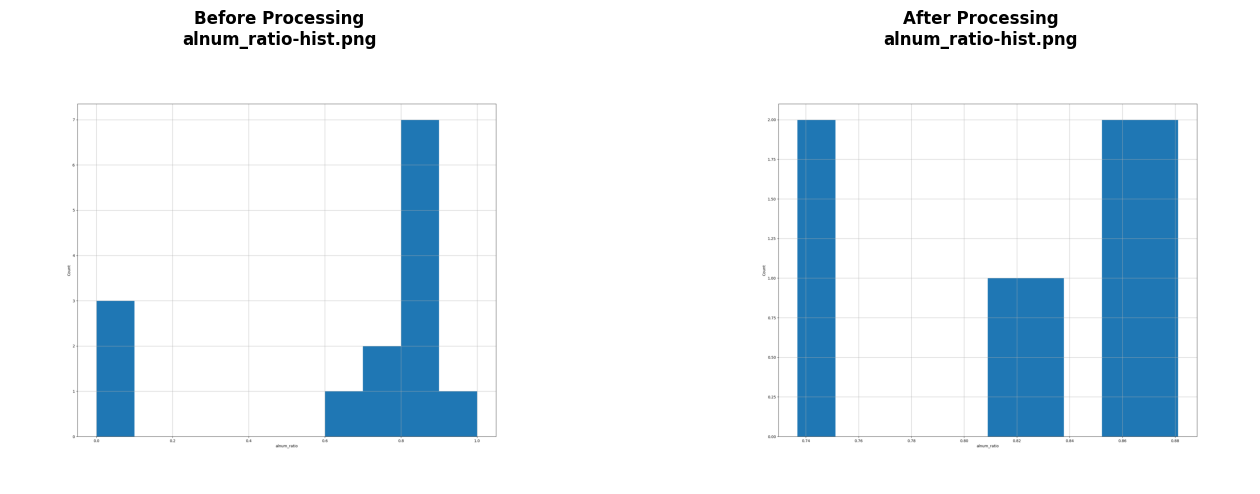

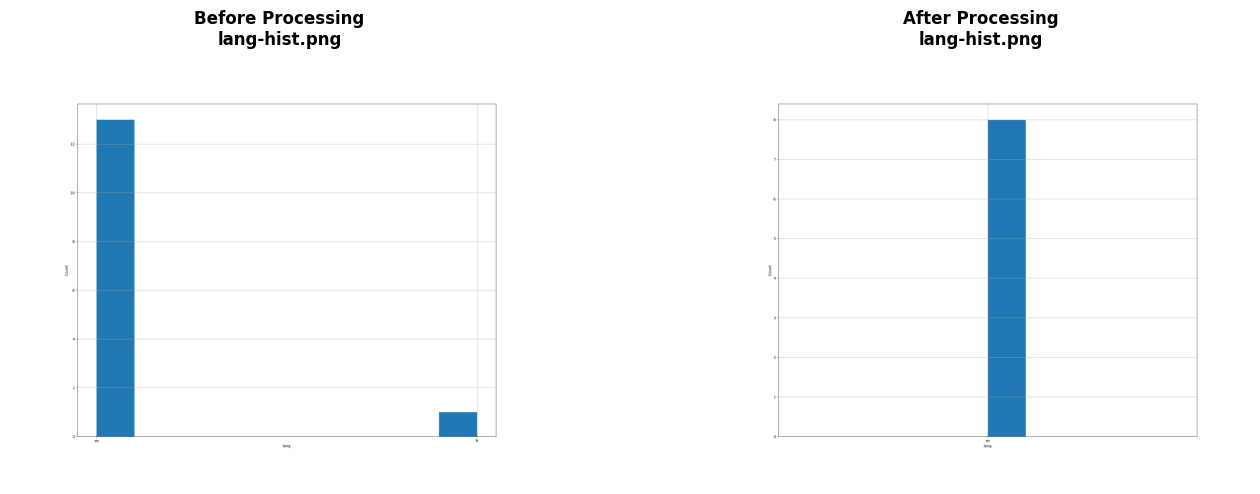

In [13]:
# Compare Before and After Processing
import matplotlib.gridspec as gridspec

before_dir = './outputs/analysis_demo/analysis'
after_dir = './outputs/processed_analyzed/analysis'

# Get PNG files from both directories
before_files = sorted([f for f in os.listdir(before_dir) if f.endswith('.png')]) if os.path.exists(before_dir) else []
after_files = sorted([f for f in os.listdir(after_dir) if f.endswith('.png')]) if os.path.exists(after_dir) else []

if before_files and after_files:
    print(f"Comparing {len(before_files)} visualizations before and after processing\n")
    
    # Compare matching files
    for i, (before_file, after_file) in enumerate(zip(before_files[:3], after_files[:3])):
        before_path = os.path.join(before_dir, before_file)
        after_path = os.path.join(after_dir, after_file)
        
        before_img = Image.open(before_path)
        after_img = Image.open(after_path)
        
        # Create side-by-side comparison
        fig = plt.figure(figsize=(16, 6))
        gs = gridspec.GridSpec(1, 2, figure=fig, wspace=0.3)
        
        # Before processing
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.imshow(before_img)
        ax1.set_title(f'Before Processing\n{before_file}', fontsize=12, fontweight='bold')
        ax1.axis('off')
        
        # After processing
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.imshow(after_img)
        ax2.set_title(f'After Processing\n{after_file}', fontsize=12, fontweight='bold')
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print("Missing analysis directories or no visualization files found")
    if not before_files:
        print(f"  - Before: {before_dir} not found or empty")
    if not after_files:
        print(f"  - After: {after_dir} not found or empty")

## Further Reading

- [Analysis Tools](https://github.com/datajuicer/data-juicer/blob/main/tools/analyze_data.py)
- [Operators Documentation](https://datajuicer.github.io/data-juicer/en/main/docs/Operators.html)